In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

## Neaurant artificiel

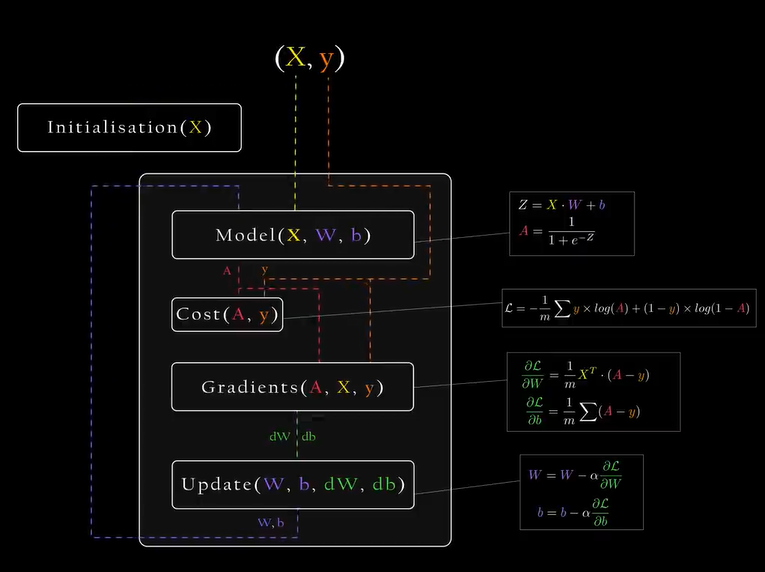

## Les fonctions d'activations

In [2]:
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)

In [3]:
def derivative_tanh(x):
    return (1 - np.power(np.tanh(x), 2))

def derivative_relu(x):
    return np.array(x > 0, dtype = np.float32)

# Initialisation

In [4]:
def initialize_parameters(n_x, n_h, n_y):
    w1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    
    w2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }
    
    return parameters

# Forward propagation

In [5]:
def forward_propagation(x, parameters):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    z1 = np.dot(w1, x) + b1
    a1 = tanh(z1)
    
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)
    
    forward_cache = {
        "z1" : z1,
        "a1" : a1,
        "z2" : z2,
        "a2" : a2
    }
    
    return forward_cache

In [6]:
def predit(x, parameters):
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    z1 = np.dot(w1, x) + b1
    a1 = tanh(z1)
    
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)
    
    return np.argmax(a2)

# Fonction cout 

In [7]:
def cost_function(a2, y):
    m = y.shape[1]
    
    cost = -(1/m)*np.sum(y*np.log(a2))
    
    return cost

# Back propagation

In [8]:
def backward_prop(x, y, parameters, forward_cache):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    a1 = forward_cache['a1']
    a2 = forward_cache['a2']
    
    m = x.shape[1]
    
    dz2 = (a2 - y)
    dw2 = (1/m)*np.dot(dz2, a1.T)
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)
    
    dz1 = (1/m)*np.dot(w2.T, dz2)*derivative_tanh(a1)
    dw1 = (1/m)*np.dot(dz1, x.T)
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)
    
    gradients = {
        "dw1" : dw1,
        "db1" : db1,
        "dw2" : dw2,
        "db2" : db2
    }
    
    return gradients

# Mise a jour des parametre

In [9]:
def update_parameters(parameters, gradients, learning_rate):
    
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    dw1 = gradients['dw1']
    db1 = gradients['db1']
    dw2 = gradients['dw2']
    db2 = gradients['db2']
    
    w1 = w1 - learning_rate*dw1
    b1 = b1 - learning_rate*db1
    w2 = w2 - learning_rate*dw2
    b2 = b2 - learning_rate*db2
    
    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }
    
    return parameters

# Batch

In [10]:
def model(x, y, n_h, learning_rate, iterations):
    
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    cost_list = []
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(iterations):
        
        forward_cache = forward_propagation(x, parameters)
        
        cost = cost_function(forward_cache['a2'], y)
        
        gradients = backward_prop(x, y, parameters, forward_cache)
        
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        cost_list.append(cost)
        
        if(i%(iterations/10) == 0):
            print("Cost after", i, "iterations is :", cost)
        
    return parameters, cost_list

# Mini batch

In [11]:
def create_mini_batches(x, y, batch_size):
    m = x.shape[1]  # Nombre d'exemples
    mini_batches = []
    
    # Mélangez les données et les étiquettes
    permutation = list(np.random.permutation(m))
    shuffled_x = x[:, permutation]
    shuffled_y = y[:, permutation]
    
    num_complete_minibatches = m // batch_size
    
    for k in range(0, num_complete_minibatches):
        mini_batch_x = shuffled_x[:, k * batch_size : (k + 1) * batch_size]
        mini_batch_y = shuffled_y[:, k * batch_size : (k + 1) * batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    # Gérer le cas où le nombre d'exemples n'est pas un multiple du batch_size
    if m % batch_size != 0:
        mini_batch_x = shuffled_x[:, num_complete_minibatches * batch_size :]
        mini_batch_y = shuffled_y[:, num_complete_minibatches * batch_size :]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [12]:
def model_mini_batch(x, y, n_h, learning_rate, iterations, batch_size):
    
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    cost_list = []
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(iterations):
        # Shuffling the data and dividing it into mini-batches
        mini_batches = create_mini_batches(x, y, batch_size)
        
        for mini_batch_x, mini_batch_y in mini_batches:
            forward_cache = forward_propagation(mini_batch_x, parameters)
            cost = cost_function(forward_cache['a2'], mini_batch_y)
            gradients = backward_prop(mini_batch_x, mini_batch_y, parameters, forward_cache)
            parameters = update_parameters(parameters, gradients, learning_rate)
        
        cost_list.append(cost)
        
        if i % (iterations / 10) == 0:
            print("Cost after", i, "iterations is :", cost)
        
    return parameters, cost_list

# Accuracy

In [13]:
def accuracy(inp, labels, parameters):
    forward_cache = forward_propagation(inp, parameters)
    a_out = forward_cache['a2']   # containes propabilities with shape(10, 1)
    
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    
    labels = np.argmax(labels, 0)
    
    acc = np.mean(a_out == labels)*100
    
    return acc

# Iminist

In [14]:
X_train = np.loadtxt('data_imnist/train_X.csv', delimiter = ',').T
Y_train = np.loadtxt('data_imnist/train_label.csv', delimiter = ',').T

X_test = np.loadtxt('data_imnist/test_X.csv', delimiter = ',').T
Y_test = np.loadtxt('data_imnist/test_label.csv', delimiter = ',').T

In [15]:
print("shape of X_train :", X_train.shape)
print("shape of Y_train :", Y_train.shape)
print("shape of X_test :", X_test.shape)
print("shape of Y_test :", Y_test.shape)

shape of X_train : (784, 1000)
shape of Y_train : (10, 1000)
shape of X_test : (784, 350)
shape of Y_test : (10, 350)


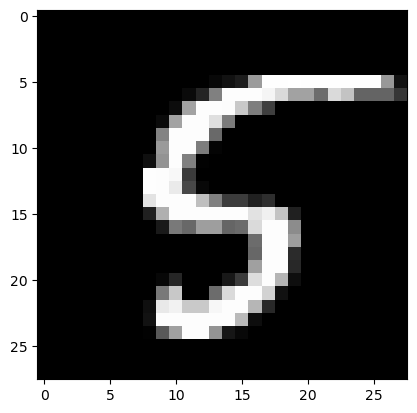

In [16]:
index = random.randrange(0, X_train.shape[1])
plt.imshow(X_train[:, index].reshape(28, 28), cmap = 'gray')
plt.show()

### Batch

In [17]:
iterations = 500
n_h = 1000
learning_rate = 0.02
Parameters, Cost_list = model(X_train, Y_train, n_h = n_h, learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 2.3624461466791895
Cost after 50 iterations is : 0.49105099937779045
Cost after 100 iterations is : 0.3155216216836044
Cost after 150 iterations is : 0.23307891844398426
Cost after 200 iterations is : 0.18248736656778908
Cost after 250 iterations is : 0.1479003622730807
Cost after 300 iterations is : 0.1228774052415744
Cost after 350 iterations is : 0.10413601200619296
Cost after 400 iterations is : 0.08974985884999967
Cost after 450 iterations is : 0.07847480190704983


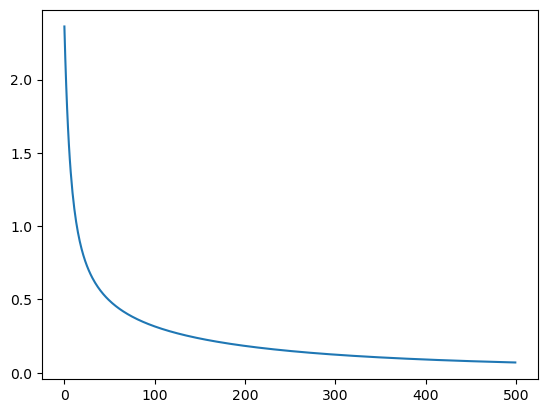

In [18]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

In [19]:
print("Accuracy of Train Dataset", accuracy(X_train, Y_train, Parameters), "%")
print("Accuracy of Test Dataset", round(accuracy(X_test, Y_test, Parameters), 2), "%")

Accuracy of Train Dataset 100.0 %
Accuracy of Test Dataset 87.14 %


### Test

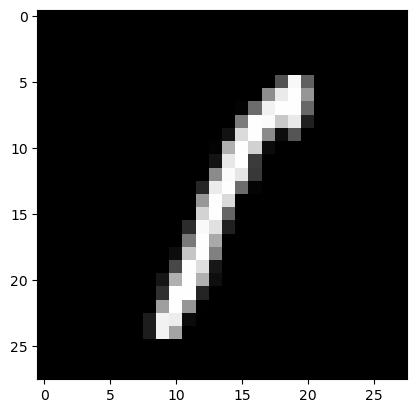

Our model says it is : 1


In [20]:
idx = int(random.randrange(0,X_test.shape[1]))
plt.imshow(X_test[:, idx].reshape((28,28)),cmap='gray')
plt.show()

a_pred = predit(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters)

print("Our model says it is :", a_pred)

### Mini batch

In [21]:
batch_size = 20
iterations = 500
n_h = 1000
learning_rate = 0.02
Parameters, Cost_list = model_mini_batch(X_train, Y_train, n_h = n_h, learning_rate = learning_rate, iterations = iterations, batch_size=batch_size)

Cost after 0 iterations is : 0.4528899747577233
Cost after 50 iterations is : 0.003248427149830848
Cost after 100 iterations is : 0.00201990360112768
Cost after 150 iterations is : 0.001272084620889833
Cost after 200 iterations is : 0.0008621051606050447
Cost after 250 iterations is : 0.0005713219217417716
Cost after 300 iterations is : 0.0003238258769325462
Cost after 350 iterations is : 0.0003061245335781481
Cost after 400 iterations is : 0.0003260141086845202
Cost after 450 iterations is : 0.00019182922531679506


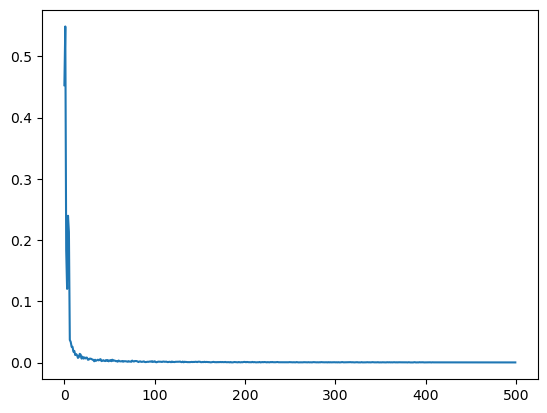

In [22]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

In [23]:
print("Accuracy of Train Dataset", accuracy(X_train, Y_train, Parameters), "%")
print("Accuracy of Test Dataset", round(accuracy(X_test, Y_test, Parameters), 2), "%")

Accuracy of Train Dataset 100.0 %
Accuracy of Test Dataset 86.29 %


### Test

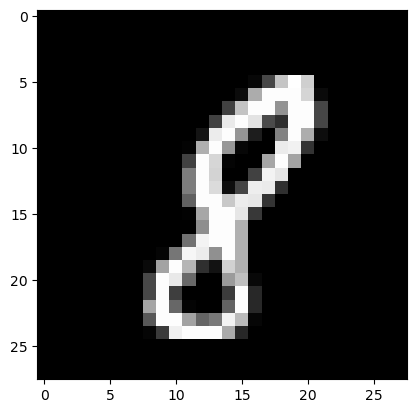

Our model says it is : 8


In [24]:
idx = int(random.randrange(0,X_test.shape[1]))
plt.imshow(X_test[:, idx].reshape((28,28)),cmap='gray')
plt.show()

a_pred = predit(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters)

print("Our model says it is :", a_pred)

# Iris

In [25]:
iris = load_iris()
X = iris.data  
Y = iris.target  

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [26]:
def one_hot_encode(Y, num_classes):
    one_hot_labels = np.zeros((len(Y), num_classes))
    for i in range(len(Y)):
        one_hot_labels[i, Y[i]] = 1
    return one_hot_labels

Y_train=one_hot_encode(Y_train, 3)
Y_test=one_hot_encode(Y_test, 3)

In [27]:
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

In [28]:
print("shape of X_train :", X_train.shape)
print("shape of Y_train :", Y_train.shape)
print("shape of X_test :", X_test.shape)
print("shape of Y_test :", Y_test.shape)

shape of X_train : (4, 120)
shape of Y_train : (3, 120)
shape of X_test : (4, 30)
shape of Y_test : (3, 30)


### Batch

In [29]:
iterations = 1000
n_h = 1000
learning_rate = 0.02
Parameters, Cost_list = model(X_train, Y_train, n_h = n_h, learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 1.1049239912339968
Cost after 100 iterations is : 0.9557451047621214
Cost after 200 iterations is : 0.8519289163295491
Cost after 300 iterations is : 0.769883652768379
Cost after 400 iterations is : 0.7045124714647362
Cost after 500 iterations is : 0.6520534629339029
Cost after 600 iterations is : 0.6095208721724328
Cost after 700 iterations is : 0.5745520144043297
Cost after 800 iterations is : 0.545323089463516
Cost after 900 iterations is : 0.5204565253975859


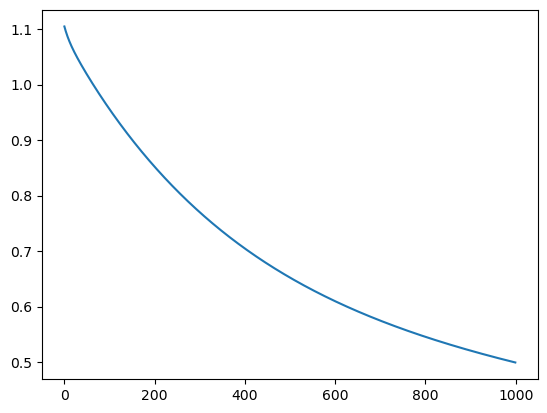

In [30]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

In [31]:
print("Accuracy of Train Dataset", accuracy(X_train, Y_train, Parameters), "%")
print("Accuracy of Test Dataset", round(accuracy(X_test, Y_test, Parameters), 2), "%")

Accuracy of Train Dataset 93.33333333333333 %
Accuracy of Test Dataset 86.67 %


### Test

In [32]:
idx = int(random.randrange(0,X_test.shape[1]))

cache = forward_propagation(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters)
a_pred = cache['a2']  
Y = Y_test.reshape(30, 3)
print("the true value is : ", np.argmax(Y[idx]))

t = predit(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters)
print ("Our model says it is : ", t)

the true value is :  0
Our model says it is :  1


### Mini Batch

In [33]:
batch_size = 20
iterations = 1000
n_h = 1000
learning_rate = 0.02
Parameters, Cost_list = model_mini_batch(X_train, Y_train, n_h = n_h, learning_rate = learning_rate, iterations = iterations, batch_size=batch_size)

Cost after 0 iterations is : 1.0982328898861375
Cost after 100 iterations is : 0.4032160385939575
Cost after 200 iterations is : 0.2919631532596998
Cost after 300 iterations is : 0.18287892606004377
Cost after 400 iterations is : 0.13427359820447646
Cost after 500 iterations is : 0.1561218134702247
Cost after 600 iterations is : 0.10591111997302756
Cost after 700 iterations is : 0.1756626453842513
Cost after 800 iterations is : 0.10687961236496955
Cost after 900 iterations is : 0.07400273112076933


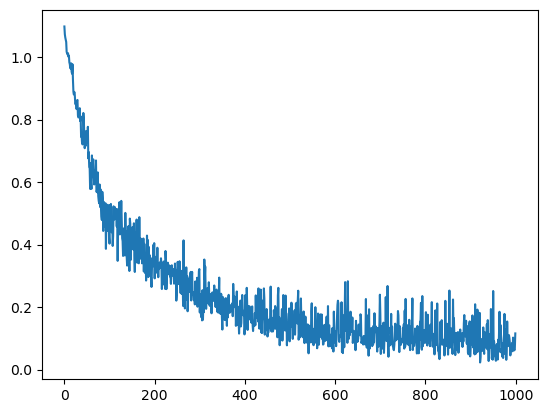

In [34]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

In [35]:
print("Accuracy of Train Dataset", accuracy(X_train, Y_train, Parameters), "%")
print("Accuracy of Test Dataset", round(accuracy(X_test, Y_test, Parameters), 2), "%")

Accuracy of Train Dataset 98.33333333333333 %
Accuracy of Test Dataset 100.0 %


### Test

In [36]:
idx = int(random.randrange(0,X_test.shape[1]))

cache = forward_propagation(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters)
a_pred = cache['a2']  
Y = Y_test.reshape(30, 3)
print("the true value is : ", np.argmax(Y[idx]))

t = predit(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters)
print ("Our model says it is : ", t)

the true value is :  1
Our model says it is :  0
